In [1]:
import random
import math
from time import sleep, time
from itertools import count
from collections import deque, namedtuple
from tqdm.notebook import trange, tqdm
try:
    import gym
except ModuleNotFoundError:
    !pip install gym
    !pip install ale-py
    !pip install gym[atari]
    !pip install gym[accept-rom-license]
    import gym
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torchvision import transforms
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
to_tensor = lambda x: torch.tensor(x, device=dev)

In [2]:
env = gym.make("ALE/Pong-v5", repeat_action_probability=0, render_mode='human')
state = env.reset()

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [3]:
# Play
def play(policy, runs=1, wait=0):
    for _ in trange(runs):
        state = env.reset()
        for _ in count():
            state, reward, done, info = env.step(policy(state))
            plt.imshow(env.render(mode='rgb_array'))

            if done:
                break
            sleep(wait)

In [4]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.queue = deque([], maxlen=capacity)
        
    def __len__(self):
        return len(self.queue)
        
    def push(self, *args):
        self.queue.append(Transition(*args))

    def sample(self, batchsize):
        return random.sample(self.queue, batchsize)

In [5]:
def save(net, losses, rewards):
    torch.save({
        'net': net.state_dict(),
        'losses': losses,
        'rewards': rewards
    }, 'chkpnt.pt')

def load():
    chkpnt = torch.load('./chkpnt.pt', map_location=torch.device(dev))
    return chkpnt['net'], chkpnt['losses'], chkpnt['rewards']

In [6]:
class DQN(nn.Module): # size((210, 160, 3)) -> size(6)
    def __init__(self):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 8, 4),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 4, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.l = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, env.action_space.n)
        )
        self.flat = nn.Flatten()
        self.transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Grayscale(),
            transforms.Resize((110, 84)),
            transforms.CenterCrop((84, 84))
        ])
    
    def transforms(self, x):
        return self.transformations(x).to(dev)
    
    def forward(self, x):
        if len(x) < 4:
            x = x.unsqueeze(0)
        x = self.conv(x)
        x = self.flat(x)
        return self.l(x)


net = DQN().to(dev)
target_net = DQN().to(dev)
memory = ReplayMemory(25000)
losses = []
rewards = []
try:
    state_dict, losses, rewards = load()
    net.load_state_dict(state_dict)
except FileNotFoundError:
    pass
target_net.load_state_dict(net.state_dict())
# net(net.transforms(state)).shape

<All keys matched successfully>

In [7]:
def optimize_model(memory, net, target_net, criterion, optim):
    # Update weights
    transition_batch = memory.sample(BS)

    states = to_tensor(np.array([(batch[0]) for batch in transition_batch]))
    next_states = torch.cat(
        [net.transforms(batch[2]).unsqueeze(0) for batch in transition_batch])
    future_q = target_net(next_states)
    
    Y = net(states)
    for i, (state, action, next_state, reward, done) in enumerate(transition_batch):
        reward = to_tensor(reward)
    
        y = reward if done else reward + gamma*torch.max(future_q[i])
        Y[i][action] = y

    for p in net.parameters():
        p.grad = None
    loss = criterion(Y, net(states))

    loss.backward()
    optim.step()
    return loss.item()

0.001540612487879116

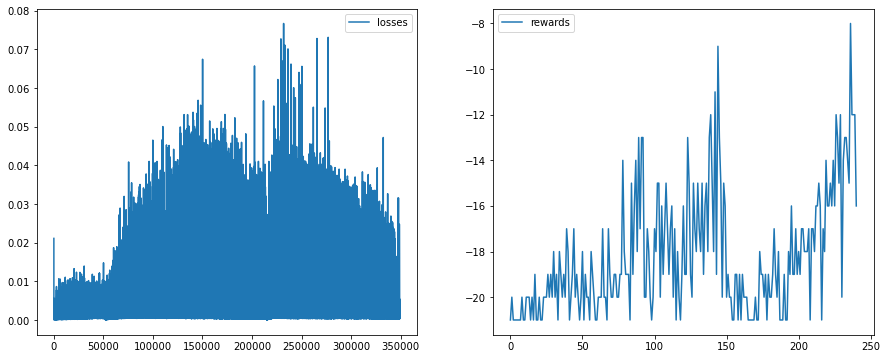

In [8]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(15, 6, forward=True)

axs[0].plot(losses, label='losses')
axs[1].plot(rewards, label='rewards')

[ax.legend() for ax in axs]
np.array(losses[-100:]).mean()

In [9]:
n_episodes = 1000
gamma = 0.99
BS = 64
C = 1000 # update target

EPS_START = 1
EPS_END = 0.02
EPS_DECAY = 0.00002
get_eps = lambda steps_done: EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done * EPS_DECAY)

criterion = nn.MSELoss()
optim = torch.optim.Adam(net.parameters(), lr=5e-5)

steps_done = 0
target_count = 0
for episode in (tr := trange(len(rewards), n_episodes)):
    rewards.append(0)
    state = net.transforms(env.reset())
    for t in count():
        eps_threshold = get_eps(steps_done)
        steps_done += 1
        
        if np.random.uniform(0, 1) < eps_threshold:
            action = env.action_space.sample()
        else:
            action = torch.argmax(net(state)).item()
        next_state, reward, done, info = env.step(action)
        rewards[episode] += reward
        memory.push(state.cpu().numpy(), action, next_state, reward, done)

        if len(memory) >= BS:
            loss = optimize_model(memory, net, target_net, criterion, optim)
            losses.append(loss)
            tr.set_description(f'Loss {loss:.4f}, Reward {rewards[-1]:04.1f}, Step {t:04d}')
        else:
            tr.set_description(f'Reward {rewards[-1]:04.1f}, Step {t:04d}')

        state = net.transforms(next_state)
        if target_count >= C:
            target_net.load_state_dict(net.state_dict())
            target_count = 0
        else:
            target_count += 1
        if done:
            break
    save(net, losses, rewards)

  0%|          | 0/759 [00:00<?, ?it/s]

KeyboardInterrupt: 

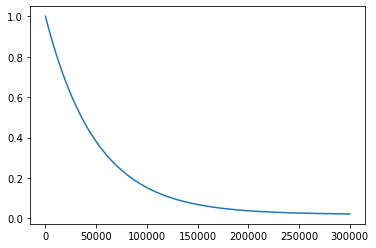

In [10]:
r = 1000 * 300
plt.plot(range(r), [get_eps(x) for x in range(r)])

0.001540612487879116

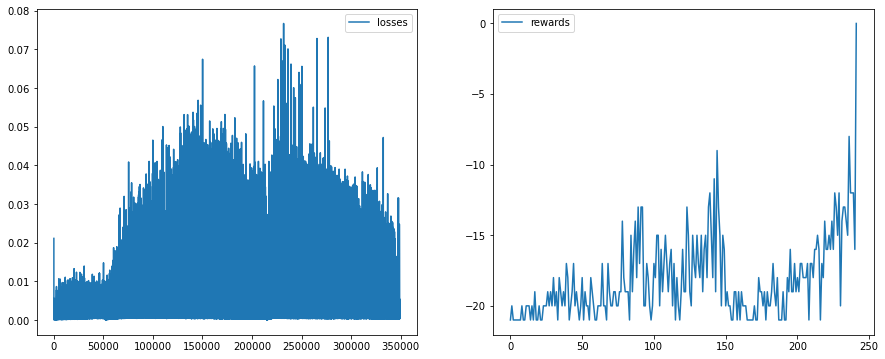

In [11]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(15, 6, forward=True)

axs[0].plot(losses, label='losses')
axs[1].plot(rewards, label='rewards')

[ax.legend() for ax in axs]
np.array(losses[-100:]).mean()

In [ ]:
def policy(state):
     return torch.argmax(net(net.transforms(state))).item()
play(policy, runs=1, wait=0)

  0%|          | 0/1 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:305: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps
  logger.warn(
